Group 25 Project

Doris (33996984)

Verness Chin (52924784)

Mackenzie Dy (62709126)

Kunyue Liu (94258175)

Title: Heart Failure

In [6]:
import altair as alt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_failure_clinical_records = fetch_ucirepo(id=519) 
  
# data (as pandas dataframes) 
X = heart_failure_clinical_records.data.features 
y = heart_failure_clinical_records.data.targets 
  
# metadata 
print(heart_failure_clinical_records.metadata) 
  
# variable information 
print(heart_failure_clinical_records.variables) 

In [4]:
url = 'https://archive.ics.uci.edu/static/public/519/data.csv'
data = pd.read_csv(url)
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


Method:
    
    
Data Preparation
Data Selection: Select only the relevant columns, which are "Serum creatinine," "Ejection fraction," and "Death event."
Data Splitting: Using ‘train_test_split” function to split the data into two datasets, one for training purposes (75%) and one for testing purposes (25%).
 
KNN Model Building:
Create a preprocessor to standardize the "Serum creatinine" and "Ejection fraction" columns to have a mean of 0 and a standard deviation of 1.
 
Choosing K: To pick an appropriate value for K, the number of nearest neighbors to consider, 5-fold cross-validation will be applied. A grid search model will be created to find the optimal K value that minimizes errors.
Training: Building the KNN model with the value of K obtained from the Choosing K on the training data using the standardized "Serum creatinine" and "Ejection fraction" columns as input features and "Death event" as the target variable. Then pass the training data and model specification utilizing “fit” function.
 
Model Evaluation and visualization:
Testing: Use the testing data to evaluate the KNN model's performance. Make predictions for "Death event" based on "Serum creatinine" and "Ejection fraction" from the testing data.
Evaluation Metrics: Create a confusion matrix by using the crosstab function and calculate the accuracy, precision, and recall based on the metrics. The confusion matrix will show the number of true positives, true negatives, false positives, and false negatives. The “ConfusionMatrixDisplay” function will create a heatmap of the confusion matrix for better visualization


In [8]:
data["death_event"] = data["death_event"].astype(str).replace({
    '1': 'Yes',
    '0': 'No'
})
data


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,Yes
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,Yes
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,Yes
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,Yes
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,No
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,No
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,No
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,No


In [9]:
plot = alt.Chart(data).mark_point(opacity = 0.5).encode(
    x = alt.X('ejection_fraction', title = "Ejection Fraction in percentage (%)"),
    y = alt.Y('serum_creatinine', title = "Serum Creatinine in mg/dL"),
     color = alt.Color('death_event', title = 'Death event')
)
plot

alt.Chart(...)

In [10]:
heart_disease_train, heart_disease_test = train_test_split(data, test_size=0.25, random_state=123)
heart_disease_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
107,45.0,1,1876,1,35,0,226000.0,0.9,138,1,0,88,No
5,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,Yes
206,40.0,1,101,0,40,0,226000.0,0.8,141,0,0,187,No
276,70.0,0,618,0,35,0,327000.0,1.1,142,0,0,245,No
258,45.0,1,66,1,25,0,233000.0,0.8,135,1,0,230,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,55.0,0,748,0,45,0,263000.0,1.3,137,1,0,88,No
83,79.0,1,55,0,50,1,172000.0,1.8,133,1,0,78,No
17,45.0,0,582,0,14,0,166000.0,0.8,127,1,0,14,Yes
230,60.0,0,166,0,30,0,62000.0,1.7,127,0,0,207,Yes


In [11]:
heart_disease_test

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
202,70.0,0,97,0,60,1,220000.0,0.9,138,1,0,186,No
114,60.0,1,754,1,40,1,328000.0,1.2,126,1,0,91,No
164,45.0,0,2442,1,30,0,334000.0,1.1,139,1,0,129,Yes
277,70.0,0,582,1,38,0,25100.0,1.1,140,1,0,246,No
292,52.0,0,190,1,38,0,382000.0,1.0,140,1,1,258,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,90.0,1,60,1,50,0,226000.0,1.0,134,1,0,30,Yes
143,61.0,1,84,0,40,1,229000.0,0.9,141,0,0,110,No
21,65.0,1,128,1,30,1,297000.0,1.6,136,0,0,20,Yes
259,53.0,0,56,0,50,0,308000.0,0.7,135,1,1,231,No


In [12]:
heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), ["ejection_fraction", "serum_creatinine"]),
    remainder= 'passthrough',
     verbose_feature_names_out=False
 )
heart_disease_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['ejection_fraction', 'serum_creatinine'])],
                  verbose_feature_names_out=False)

In [14]:
knn_spec = KNeighborsClassifier(n_neighbors=6)
heart_disease_train.columns = heart_disease_train.columns.str.strip()
X = heart_disease_train[["ejection_fraction", "serum_creatinine"]]
y = heart_disease_train["death_event"]
X = X.astype(float)  

heart_disease_fit = make_pipeline(heart_disease_preprocessor, knn_spec)
heart_disease_fit = heart_disease_fit.fit(X,y)
heart_disease_fit 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ejection_fraction',
                                                   'serum_creatinine'])],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=6))])

In [18]:
heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[["ejection_fraction", "serum_creatinine"]])
)
heart_disease_test_predictions

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,predicted
202,70.0,0,97,0,60,1,220000.0,0.9,138,1,0,186,No,No
114,60.0,1,754,1,40,1,328000.0,1.2,126,1,0,91,No,No
164,45.0,0,2442,1,30,0,334000.0,1.1,139,1,0,129,Yes,No
277,70.0,0,582,1,38,0,25100.0,1.1,140,1,0,246,No,No
292,52.0,0,190,1,38,0,382000.0,1.0,140,1,1,258,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,90.0,1,60,1,50,0,226000.0,1.0,134,1,0,30,Yes,No
143,61.0,1,84,0,40,1,229000.0,0.9,141,0,0,110,No,No
21,65.0,1,128,1,30,1,297000.0,1.6,136,0,0,20,Yes,No
259,53.0,0,56,0,50,0,308000.0,0.7,135,1,1,231,No,No


In [19]:
X_test = heart_disease_test_predictions[["ejection_fraction", "serum_creatinine"]]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.6933333333333334

In [20]:
mat = pd.crosstab(
     heart_disease_test_predictions["ejection_fraction"],  # True labels
     heart_disease_test_predictions["serum_creatinine"],  # Predicted labels
)
mat

serum_creatinine,0.70,0.80,0.90,1.00,1.10,1.18,1.20,1.30,1.40,1.50,...,1.90,2.10,2.20,2.30,2.40,2.50,3.00,3.50,3.70,6.80
ejection_fraction,,,,,,,,,,,,,,,,,,,,,
17,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,1,1,0,2,0,1,1,0,0,...,0,2,0,0,1,1,0,0,0,0
30,0,1,0,0,1,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
35,0,0,4,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
38,1,0,0,1,1,1,2,0,1,0,...,0,0,1,0,0,0,0,0,0,0
40,1,1,2,3,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
45,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
50,1,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


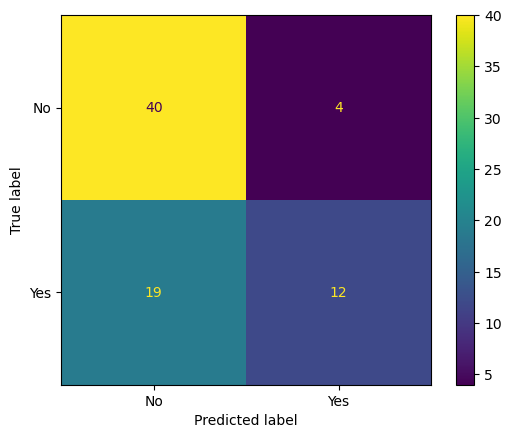

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    heart_disease_fit, 
    X_test, 
    y_test
)

In [22]:
np.random.seed(2020)
heart_disease_pipe = make_pipeline(heart_disease_preprocessor, knn_spec)
heart_disease_vfold_score = pd.DataFrame(
     cross_validate(
         estimator=heart_disease_pipe,
         cv=5,
         X=X,
         y=y,
         return_train_score=True,
     )
)
heart_disease_vfold_score

,fit_time,score_time,test_score,train_score
0,0.009912,0.008968,0.777778,0.804469
1,0.008538,0.007184,0.844444,0.804469
2,0.008363,0.007264,0.800000,0.821229
3,0.007709,0.007663,0.777778,0.810056
4,0.010622,0.006985,0.750000,0.827778


In [23]:
heart_disease_metrics = heart_disease_vfold_score.agg(["mean", "sem"])
heart_disease_metrics

,fit_time,score_time,test_score,train_score
mean,0.009029,0.007613,0.790000,0.813600
sem,0.000536,0.000356,0.015753,0.004682


In [25]:
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}
heart_disease_tune_pipe = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

In [26]:
knn_tune_grid = GridSearchCV(
    estimator = heart_disease_tune_pipe,
    param_grid = param_grid,
    cv = 5
)
knn_tune_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['ejection_fraction',
                                                                          'serum_creatinine'])],
                                                          verbose_feature_names_out=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 50)})

In [27]:
knn_model_grid = knn_tune_grid.fit(X, y)
accuracies_grid = pd.DataFrame(knn_model_grid.cv_results_)
accuracies_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008350,0.001329,0.007429,0.000482,1,{'kneighborsclassifier__n_neighbors': 1},0.733333,0.733333,0.688889,0.622222,0.659091,0.687374,0.043062,49
1,0.007847,0.000524,0.007053,0.000116,2,{'kneighborsclassifier__n_neighbors': 2},0.777778,0.755556,0.755556,0.688889,0.772727,0.750101,0.031888,40
2,0.025503,0.035883,0.007732,0.001242,3,{'kneighborsclassifier__n_neighbors': 3},0.733333,0.800000,0.733333,0.577778,0.772727,0.723434,0.077076,48
3,0.007755,0.000281,0.007239,0.000317,4,{'kneighborsclassifier__n_neighbors': 4},0.755556,0.800000,0.755556,0.688889,0.727273,0.745455,0.036632,47
4,0.007674,0.000247,0.007114,0.000063,5,{'kneighborsclassifier__n_neighbors': 5},0.755556,0.822222,0.733333,0.711111,0.750000,0.754444,0.037251,39
5,0.007882,0.000546,0.011042,0.007990,6,{'kneighborsclassifier__n_neighbors': 6},0.777778,0.844444,0.800000,0.777778,0.750000,0.790000,0.031505,4
6,0.007840,0.000357,0.010858,0.007734,7,{'kneighborsclassifier__n_neighbors': 7},0.733333,0.822222,0.755556,0.733333,0.772727,0.763434,0.032914,23
7,0.007533,0.000169,0.007117,0.000109,8,{'kneighborsclassifier__n_neighbors': 8},0.733333,0.844444,0.800000,0.755556,0.772727,0.781212,0.038403,11
8,0.007467,0.000114,0.007138,0.000090,9,{'kneighborsclassifier__n_neighbors': 9},0.755556,0.844444,0.777778,0.733333,0.795455,0.781313,0.037851,9
9,0.007459,0.000123,0.007004,0.000094,10,{'kneighborsclassifier__n_neighbors': 10},0.755556,0.822222,0.777778,0.777778,0.818182,0.790303,0.025757,2


In [28]:
accuracy_versus_k_grid = alt.Chart(accuracies_grid).mark_line(point=True).encode(
     x=alt.X("param_kneighborsclassifier__n_neighbors", title = "param kneighborsclassifier n_neighbors"),
     y=alt.Y("mean_test_score", title = "mean test score")
)
accuracy_versus_k_grid

alt.Chart(...)

In [29]:
np.random.seed(2000)

# your code here
param_grid = {'n_neighbors': range(1, 30, 1)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, return_train_score=True, n_jobs=-1)
grid_search.fit(X, y)
cv_results_df = pd.DataFrame(grid_search.cv_results_)

cross_val_plot = alt.Chart(cv_results_df).mark_line(point=True).encode(
    x = alt.X("param_n_neighbors", title ="Number of Neighbors (k)"),
    y = alt.Y("mean_test_score", title ="Accuracy")
)
cross_val_plot

alt.Chart(...)

In [ ]:
Optimal K is 6